In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import h5py

sys.path.append(r"D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src")

import wind
import windWT as wt
import windCAD
import windCodes

import winsound

# plt.rcParams['text.usetex'] = False 
# plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.family'] = 'sans-serif'

### <a id='toc2_1_1_'></a>[Files and directories](#toc0_)

In [140]:
# Directories
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/"
rawHFPIdir = workDir + r"ABL/Roof__3_12/H1/"
rawVelDir = workDir + r""
outputDir = workDir + r""
figDir = outputDir + r"__plots/"
exportDir = outputDir + r"__export/"

# Files
tapFile = workDir + r"tapDefinition.csv"

if not os.path.exists(outputDir):
    os.makedirs(outputDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)
if not os.path.exists(exportDir):
    os.makedirs(exportDir)

### <a id='toc2_1_2_'></a>[General parameters](#toc0_)

In [4]:
saveFigs = False
# exposure = 'E2'
# cases = 'c2'

# caseName_iso_OP = 'nrcNBc2E2'
# casedir_iso_OP = rawHFPIdir+caseName_iso_OP+r"/"

# caseName_iso_SU = 'nrcNBc2E3'
# casedir_iso_SU = rawHFPIdir+caseName_iso_SU+r"/"

# caseName_sur_OP = 'nrcNBc1E2'
# casedir_sur_OP = rawHFPIdir+caseName_sur_OP+r"/"

# caseName_sur_SU = 'nrcNBc1E3'
# casedir_sur_SU = rawHFPIdir+caseName_sur_SU+r"/"

# profileDir = rawVelDir 

# <a id='toc3_'></a>[Building Geometry](#toc0_)

In [17]:
H = 0.113  # average roof height
He = 0.073  # eaves height
Havg = H
Hr = He + (H-He) # ridge height
B = 0.238
D = 0.158
roofSlope = 26.565  # roof slope
site_latitude = 46.1

lScl=1/100.0
vScl=1/2.78
tScl=lScl/vScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale
dur_MS_1hr = 3600*tScl
badTaps = []

print("lScl = {:.5f}".format(lScl))
print("tScl = {:.5f}".format(tScl))
print("vScl = {:.5f}".format(vScl))
print(f"Model-scale duration = {dur_MS_1hr:.2f} seconds")

print(f"Hr = {Hr:.4f} m")

lScl = 0.01000
tScl = 0.02780
vScl = 0.35971
Model-scale duration = 100.08 seconds
Hr = 0.1130 m


### <a id='toc3_1_2_'></a>[Basics of faces](#toc0_)

In [153]:

tapData = pd.read_csv(tapFile, na_filter=False)
tapData['faceID'] = tapData['faceID'].astype(float)
tapData = tapData.dropna(subset=['faceID'])
tapData['faceID'] = tapData['faceID'].astype(int)

faceID = [1,2,3,4,5,6,7]
# name = [r'West-roof',r'East-roof',r'South-wall',r'East-wall',r'North-wall',r'West-wall',r'Bottom']
# name = ['Face-1','Face-2','Face-3','Face-4','Face-5','Face-6','Face-7']
note = ['','','','','','','']

origin = [[0, 0, 0.09275], [0, -0.079, 0.073], [-0.119, 0, 0], [0, -0.079, 0], [0.119, 0, 0], [0, 0.079, 0], [0, 0, 0], ]

basisVectors = [[[1, 0, 0], [0, 0.970142500145332, 0.242535625036333], [0, -0.242535625036333, 0.970142500145332]], 
                [[1, 0, 0], [0, 0.970142500145332, -0.242535625036333], [0, 0.242535625036333, 0.970142500145332]], 
                [[0, 0, -1], [-1, 0, 0], [0, 1, 0]], 
                [[1, 0, 0], [0, 0, -1], [0, 1, 0]], 
                [[0, 0, 1], [1, 0, 0], [0, 1, 0]], 
                [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
                [[-1, 0, 0], [0, -1, 0], [0, 0, -1]], 
                ]

origin_plt = [[0, 0], [0, -0.0814313361059488], [0, -0.2303], [0, -0.17055], [0, -0.2303], [0, -0.17055], [0, -0.2681], ]

basisVectors_plt = [[[0, -1], [1, 0]], [[0, -1], [1, 0]], [[1, 0], [0, 1]], [[0, -1], [1, 0]], [[-1, 0], [0, -1]], [[0, 1], [-1, 0]], [[0, -1], [1, 0]], ]

vertices_basic = [[[-0.119, 0], [-0.119, 0.0814313361059488], [0.119, 0.0814313361059488], [0.119, 0], [-0.119, 0], ], [[-0.119, 0], [-0.119, 0.0814313361059488], [0.119, 0.0814313361059488], [0.119, 0], [-0.119, 0], ], [[-0.079, 0], [-0.079, 0.073], [0, 0.09275], [0.079, 0.073], [0.079, 0], [-0.079, 0], ], [[-0.119, 0], [-0.119, 0.073], [0.119, 0.073], [0.119, 0], [-0.119, 0], ], [[-0.079, 0], [-0.079, 0.073], [0, 0.09275], [0.079, 0.073], [0.079, 0], [-0.079, 0], ], [[-0.119, 0], [-0.119, 0.073], [0.119, 0.073], [0.119, 0], [-0.119, 0], ], [[-0.089, -0.079], [-0.089, -0.049], [-0.119, -0.049], [-0.119, 0.049], [-0.089, 0.049], [-0.089, 0.079], [0.089, 0.079], [0.089, 0.049], [0.119, 0.049], [0.119, -0.049], [0.089, -0.049], [0.089, -0.079], [-0.089, -0.079], ], ]


### <a id='toc3_1_4_'></a>[Face objects](#toc0_)

In [154]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
# nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]],dtype=float))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    # tapName = tapData.tapName[idx]
    idxOrig = idx
    if z == 2:  # flip the y-coordinates about the centreline defined by average of the edge vertices. 
                # The aerodynamics strongly suggests that Face 2 must have been flipped in the tubing process.
        x = np.array(vertices_basic[i])
        yAvg = np.mean([min(x[:,1]), max(x[:,1])])
        tapCoords[:,1] = yAvg - (tapCoords[:,1] - yAvg)

    fc = windCAD.face(
                name=f'Face {z}', # ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                # tapName=tapName,
                tapCoord=tapCoords,
                # zoneDict=zoneDict_basic[i],
                # nominalPanelAreas=nominalPanelAreas,
                showDetailedLog=False,
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Processing face 1...
Generating panels ...
Face 1 done.



Processing face 2...
Generating panels ...
Face 2 done.



Processing face 3...
Generating panels ...
Face 3 done.



Processing face 4...
Generating panels ...
Face 4 done.



Processing face 5...
Generating panels ...
Face 5 done.



Processing face 6...
Generating panels ...
Face 6 done.



Processing face 7...
Generating panels ...
Face 7 done.





### <a id='toc3_1_5_'></a>[Building objects](#toc0_)

In [155]:
bldg_3to12 = wind.bldgCp(bldgName=r'Roof 3-12',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[0,-1],
                AoA_rotation_direction='ccw',
                caseName=r'Case 2 [x]',
                notes_Cp=r'Generic isolated case.',
                )


Refreshing Case 2 [x]...
Verifying data ...
Done refreshing Case 2 [x].



### <a id='toc3_1_6_'></a>[Geometry plots](#toc0_)

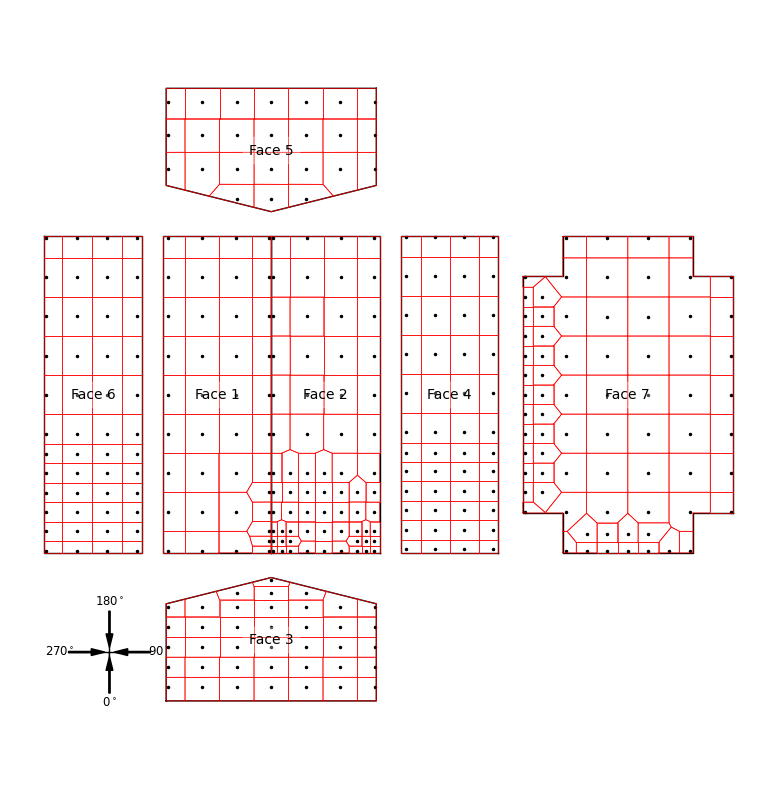

In [156]:
fig = plt.figure(figsize=[8,8])
axs = fig.subplots(1,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs
# ax.text(0.5, 0.95, r'(a) Isolated', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_3to12.plotEdges(ax=ax,showName=True)
bldg_3to12.plotTaps(ax=ax,showTapNo=False)
bldg_3to12.plotTribs(ax=ax,)
# _, legend, _ = bldg_3to12.plotZones(ax=ax)
# ax.add_artist(legend)
# legend.set_bbox_to_anchor((0.81, 0.11))
bldg_3to12.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')


plt.show()

# # if saveFigs:
# fig.savefig(figDir+"tapLayout_tex.svg",format='svg',dpi=1200, bbox_inches='tight')


In [103]:
# fig = plt.figure(figsize=[30,25])
# ax = fig.subplots(1,1)

# bldg_3to12.plotEdges(ax=ax,showName=True)
# bldg_3to12.plotTaps(ax=ax,showTapNo=True)

# ax.axis('equal')
# ax.axis('off')
# plt.show()

# # if saveFigs:
# fig.savefig(figDir+"tapNo.svg",format='svg',dpi=1200, bbox_inches='tight')

In [102]:
# fig, axs = bldg_3to12.plotPanels_AllAreas(figsize=[14,11], nCols=2, plotTaps=True,
#     areaUnit='$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.2f}', areaLabel_xy=(0.5,0.025), subPlotLabel_xy=(0.05,0.9),
#     kwargs_taps={'kwargs_dots': { 'color': 'k','ls': 'None','marker': '.','markersize': 1.5, 'alpha':1.0, 'markeredgewidth':0.0 }},
#     kwargs_zoneEdge={'color':'k', 'linewidth':0.3}
#     )
# # if saveFigs:
# # fig.savefig(figDir+"nominalPanelAreas.svg",format='svg',dpi=1200, bbox_inches='tight')

## <a id='toc4_2_'></a>[Wind tunnel](#toc0_)


### <a id='toc4_2_1_'></a>[Wind field](#toc0_)

In [ ]:
print()

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3166: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.0133 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.0032 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.013m @FS
0.0001324462900492554


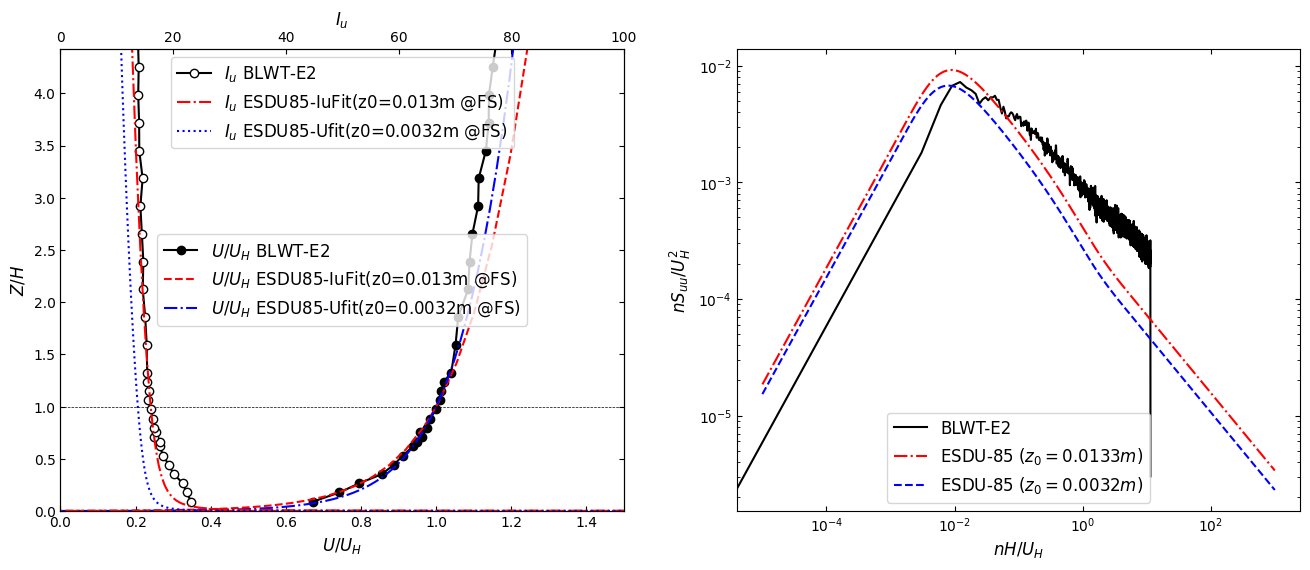

In [109]:
keepTH = True

temp = h5py.File(r"D:/tempData_depot/simData_CandC/wt_tngE2/"+r"tngE2Fr1_forPython.mat", 'r')
wtVel = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, 
                        workSect_zLim=[0, 0.5], lScl=lScl,
                        keepTH=keepTH)
wtVel.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.001, 
                        'kwargs_z0Fit':{'z0i':[1e-10,1.0]},}
wtVel.fit_z0(debugMode=True, )
print(wtVel.z0_Iu)


### <a id='toc4_2_2_'></a>[Pressure](#toc0_)

In [105]:
analogChannels_idxs={
                'main_pitot': 0,
                'xcheck_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2309,
                'main_pitot_queue': 2310,
                '20inch_pitot_zero': 2307,
                '20inch_pitot_queue': 2308,
                'Uh_pitot_zero': 2305,
                'Uh_pitot_queue': 2306,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 16
peakSpecs['Duration'] = 16
peakSpecs['prob_non_excd'] = 0.8

In [141]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=rawHFPIdir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    # lowpassFreq=200.0,
    Ntaps=352,
    trimTimeStart=0,
    trimTimeEnd=dur_MS_1hr,
)
winsound.Beep(1000, 1000)


Reading HFPI data from: D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/ABL/Roof__3_12/H1/
   Reading file: D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/ABL/Roof__3_12/H1/KATEh1E01R001P001a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/ABL/Roof__3_12/H1/KATEh1E01R001P002a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/ABL/Roof__3_12/H1/KATEh1E01R001P003a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/ABL/Roof__3_12/H1/KATEh1E01R001P004a.pssd
   Reading file: D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/Downburst+ABL+ElevatedBldgs/Data_reprocessing/ABL/Roof

Re-scaling profile to match Uref ...
    Uref_avg = 11.047 m/s
    U_ref_prof = 7.917 m/s
    U_ratio = 1.395
    time_ratio = 0.717
Refreshing 3:12 roof...
Verifying data ...
Computing Cp statistics ...
Done refreshing 3:12 roof.

Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
Message from ESDU85: Functionality for zero-plane displacement is not implemented yet.
Message from ESDU85: Functionality for uncertainty bounds is not implemented yet.
No velocity time history found for ESDU-85 ($z_0=0.0133 m$). Skipping velocity statistics calculation.
No velocity time history found for ESDU-85 ($z_0=0.0032 m$). Skipping velocity statistics calculation.
Fitted z0 = 0.013m @FS


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:773: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:3166: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


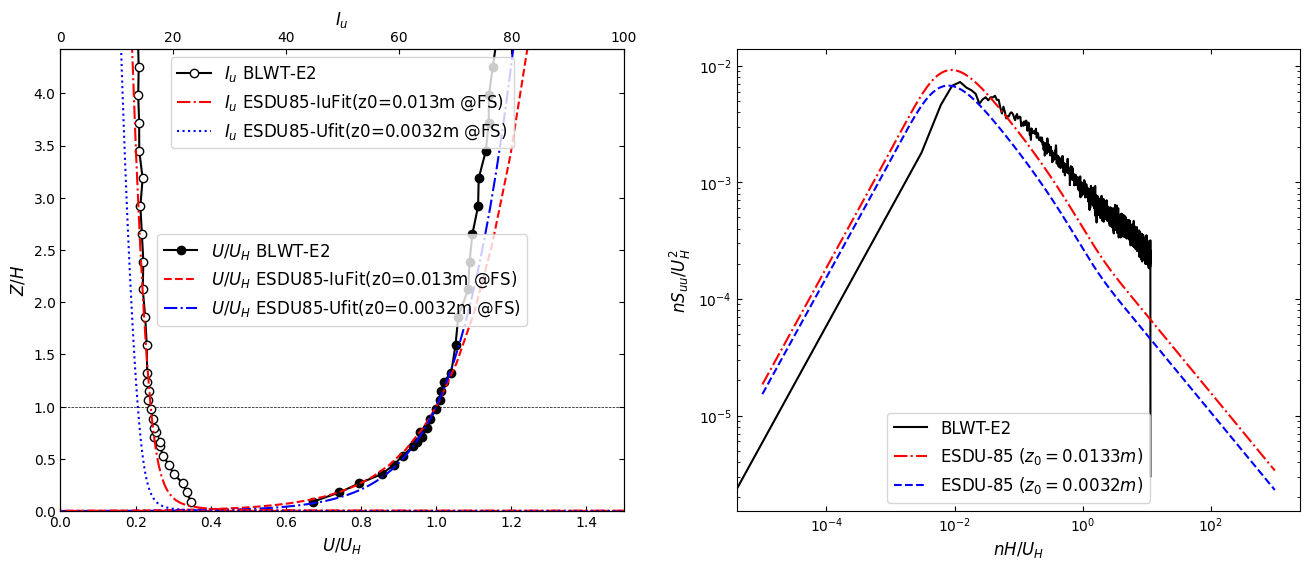

In [157]:

s, e = cp_raw.trimTimeStartIdx, cp_raw.trimTimeEndIdx
cp_3to12 = wind.bldgCp(
                bldgName=bldg_3to12.name,
                faces=bldg_3to12.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_3to12.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_3to12.AoA_rotation_direction,
                # caseName=caseName_iso_OP,
                caseName='3:12 roof',
                refProfile=wtVel,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                # Uref_FS=ve
                vScl=vScl,
                samplingFreq=cp_raw.sampleRate,
                notes_Cp=cp_raw.description,
                AoA=cp_raw.AoA,
                # CpOfT=cp_raw.CpTH[:,:,s:e],
                CpOfT=cp_raw.CpTH,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
cp_3to12.profile.fit_z0()
winsound.Beep(1000, 1000)


# <a id='toc5_'></a>[Plot results](#toc0_)

#### <a id='toc5_1_2_2_'></a>[Selected profiles and spectra](#toc0_)

#### <a id='toc5_1_2_3_'></a>[WT vs. Field vs. ESDU](#toc0_)

In [113]:
# profs = wind.Profiles([cp_3to12.profile, ])# , ])

# fig, axs = profs.plotProfile_basic2(figsize=[10,11],
#             yLimits=[0,5],
#             xLimits_U=[0, 2], xLimits_uw=[-0.08, 0.01], 
#             xLimits_Iu=[0,0.6], xLimits_Iv=[0,0.6], xLimits_Iw=[0,0.6], 
#             xLimits_xLu=[0, 50], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
#             kwargs_plt=[{'color': 'r', 'linewidth':0.5, 'linestyle': 'None',    'marker': 's', 'markersize':4, 'markerfacecolor':'w'},
#                         {'color': 'b', 'linewidth':0.5, 'linestyle': 'None',    'marker': 'o', 'markersize':4, 'markerfacecolor':'w'},
#                         {'color': 'r', 'linewidth':1.5, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#                         {'color': 'b', 'linewidth':1.5, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#                         {'color': 'k', 'linewidth':1.5, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#                         {'color': 'm', 'linewidth':1.5, 'linestyle': ':',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#                         ],
#             lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
#             kwargs_ax={'gridMajor':False}
#             )
# fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
# # if saveFigs:
# fig.savefig(figDir+"profiles.svg",format='svg',dpi=1200, bbox_inches='tight')

In [114]:
# clb = 0.4
# r = [1.0, clb, clb, 1.0]
# b = [clb, clb, 1.0, 1.0]
# kwargs_plt=[{'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 's', 'markersize':2},
#             {'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 'o', 'markersize':2},
#             {'color': 'r', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#             {'color': 'b', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#             {'color': 'k', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
#             ]
# # fieldData['name'] = 'Field measurements'


# fig, _ = profs.plotSpectra(figsize=[16,5], xLimits=[5e-4, 5e0], yLimits=[[1e-6,1e-1],[1e-6,1e-1],[1e-6,1e-1]],
#                       xLabel=r'$nH/U_h$', yLabel_Suu=r'$nS_{uu}/U_h^2$', yLabel_Svv=r'$nS_{vv}/U_h^2$', yLabel_Sww=r'$nS_{ww}/U_h^2$', 
#                       overlayThese=fieldData, overlayType='all_and_avg', lgnd_kwargs={'loc': 'lower left', 'ncol': 1}, markTheseFreq=[],
#                       kwargs_overlay = {'color': 'k', 
#                                         'linewidth':2, 
#                                         'linestyle': '-',
#                                 },
#                       kwargs_overlay_all = {'color': 'gray',
#                                         'linewidth':0.5,
#                                         'linestyle': '-',
#                                 },
#                         kwargs_plt=kwargs_plt,)
# # # if saveFigs:
# fig.savefig(figDir+'spectra_West.svg', format='svg',dpi=600, bbox_inches='tight')
# #                 # fig.savefig(figDir+'spectra.png', format='png',dpi=600, bbox_inches='tight')
# # print(f"Figure saved: {figDir}/spectra.svg")

### <a id='toc5_1_3_'></a>[Pressure](#toc0_)
#### <a id='toc5_1_3_1_'></a>[$C_p$ contours](#toc0_)

(-0.1964325, 0.3729825, -0.25333, 0.25333)

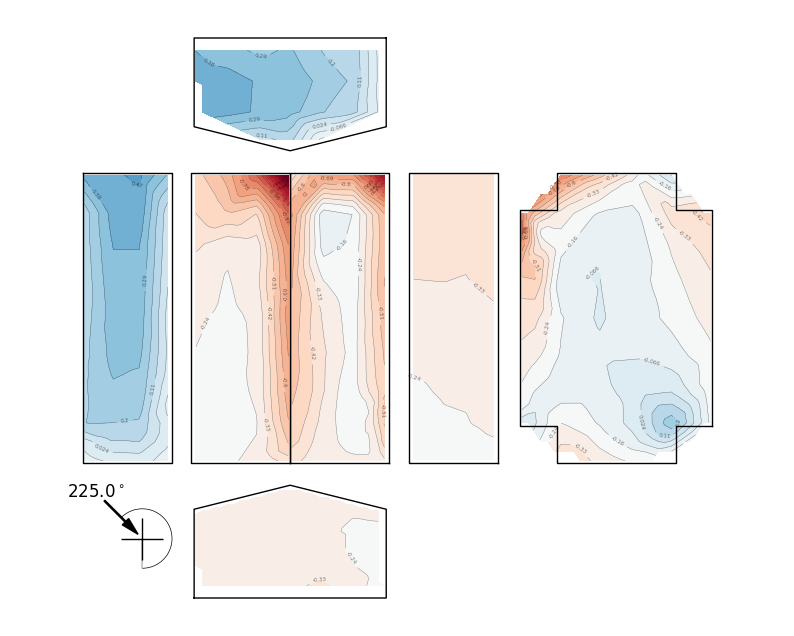

In [160]:
fig = plt.figure(figsize=[10,8])
ax = fig.subplots(1,1)
idx = 1
_ = cp_3to12.plotEdges(ax=ax, showName=False)
_ = cp_3to12.plotTapCpStatContour(fieldName='mean', dxnIdx=idx, ax=ax, fldRange=[-1.5, 1.1],nLvl=30)
_ = cp_3to12.plotAoA_definition(ax=ax, AoAs=[cp_3to12.AoA[idx],])

ax.axis('equal')
ax.axis('off')


#### <a id='toc5_1_3_2_'></a>[$C_p$ vs. AoA per tap](#toc0_)

In [42]:
# cps = wind.BldgCps([cp_iso_OP, cp_iso_SU, cp_sur_OP, cp_sur_SU])
cps = wind.BldgCps([cp_sur_SU, ] )
# cps = wind.BldgCps([cp_iso_OP, cp_sur_OP])
# cps = wind.BldgCps([cp_iso_SU, cp_sur_SU])
# cps = wind.BldgCps([cp_sur_OP, cp_sur_SU])

factors_WT = []
for cp in cps.memberBldgs:
    print(cp.name)
    factors_WT.append(cp.CandCLoad_factor(debugMode=True, format='NBCC'))

Number of member bldgs: 1
BLWT-SU-sur
Computing C&C Load factor for BLWT-SU-sur ...
full_scale_duration = 3599.9999999999995
z0 = 0.00146m (@MS), 0.146m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.146 		---> 	 0.03	===>	0.755
Z		8 		---> 	 10	===>	0.897
gust_dur	3600 		---> 	 3600	===>	1
			COMBINED FACTOR			0.6776

C&C factor for case BLWT-SU-sur = 0.6776393717768808


In [43]:
# # for the Ottawa site
# z0,es_OT = wind.fitESDUgivenIuRef(10, 0.2174)
# print(z0)

# import copy
# correctionFactor = windCodes.CpConversionFactor(from_='simulated', to_='NBCC', from_gustDuration=15*60, debugMode=True, from_Z=H_FS, from_z0=z0, )
# # deep copy the data
# fs_CpData_corrected = copy.deepcopy(fs_CpData)
# for key in fs_CpData_corrected.keys():
#     if key == 'AoA':
#         continue
#     fs_CpData_corrected[key] *= correctionFactor

In [44]:

import copy
correctionFactor = windCodes.CpConversionFactor(from_='simulated', to_='NBCC', from_gustDuration=15*60, debugMode=True, from_Z=H_FS, from_z0=es85_Fld_mnl_obj.z0_Iu, )
# deep copy the data
fs_CpData_corrected = copy.deepcopy(fs_CpData)
for key in fs_CpData_corrected.keys():
    if key == 'AoA':
        continue
    fs_CpData_corrected[key] *= correctionFactor



Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.462 		---> 	 0.03	===>	0.542
Z		9.81 		---> 	 10	===>	0.988
gust_dur	900 		---> 	 3600	===>	1.09
			COMBINED FACTOR			0.5853



In [45]:
print(cp_3to12.Uref_FS)

None


Number of member bldgs: 4
TO DO: avoid displaying 'nan'. Instead display '-'


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:1850: UserWarning: z0_Iu and z0_U are not close. Using z0_U to calculate shear velocity.
  warnings.warn("z0_Iu and z0_U are not close. Using z0_U to calculate shear velocity.")


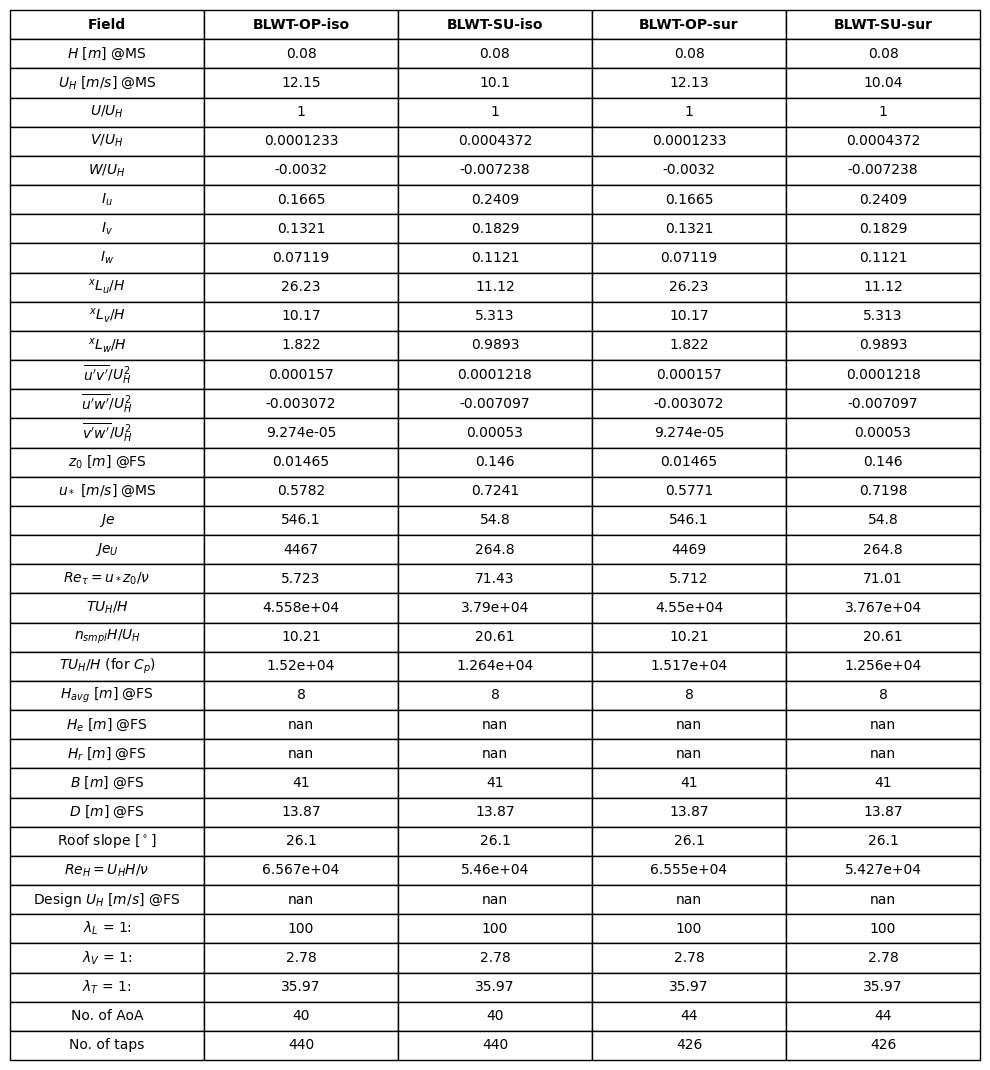

In [46]:
wt_all = wind.BldgCps([cp_3to12, cp_iso_SU, cp_sur_OP, cp_sur_SU,])
fig, _ = wt_all.plotParamsTable()
if saveFigs:
    fig.savefig(figDir+"wt_all_paramsTable.svg",format='svg',dpi=1200, bbox_inches='tight')
    print(f"Figure saved to {figDir}wt_all_paramsTable.svg")

In [47]:
idx = cp_sur_SU.tapIdxOf(fullScaleTaps)
aoa = cp_sur_SU.AoA
cpPeak = cp_sur_SU.CpStats['peakMin'][:,idx]*factors_WT[0]
print(np.shape(cpPeak))

print(fs_CpData.keys())
fld_aoa = fs_CpData['AoA']
fld_cp = fs_CpData['peakMin']*correctionFactor

# sort the data by AoA
idx = np.argsort(fld_aoa)
fld_aoa = fld_aoa[idx]
fld_cp = fld_cp[idx,:]

# interpolate the simulated data to the same AoA as the field data
cpPeak_interp = np.zeros(np.shape(fld_cp))
for i in range(np.shape(fld_cp)[1]):
    cpPeak_interp[:,i] = np.interp(fld_aoa, aoa, cpPeak[:,i])

# get difference between the field and simulated data
cpPeak_diff = cpPeak_interp - fld_cp
cpPeak_diff_mean = np.mean(cpPeak_diff, axis=0)

cpPeak_ratio = fld_cp / cpPeak_interp
cpPeak_ratio_mean = np.mean(cpPeak_ratio, axis=0)

print(np.shape(cpPeak_diff))
print(np.shape(cpPeak_diff_mean))
print(cpPeak_diff_mean)
print(np.mean(cpPeak_diff_mean))

print(np.shape(cpPeak_ratio))
print(np.shape(cpPeak_ratio_mean))
print(cpPeak_ratio_mean)
print(np.mean(cpPeak_ratio_mean))

# # plot the difference
# fig = plt.figure(figsize=[12,6])
# ax = fig.subplots(1,1)
# ax.plot(fullScaleTaps, cpPeak_diff_mean, 'k-', label='Mean')
# ax.plot(fullScaleTaps, cpPeak_diff.T, 'k.', label='All')
# ax.set_xlabel('Tap index')
# ax.set_ylabel(r'$C_p$ difference')
# ax.set_title('Difference between simulated and field data')
# ax.legend()
# ax.grid(True)
print(6*2.8)

(44, 14)
dict_keys(['AoA', 'mean', 'std', 'peakMin', 'peakMax'])
(45, 14)
(14,)
[2.53040807 4.60227174 4.23523413 3.42605992 3.84981398 4.53037608
 4.19055741 3.83811075 2.95111363 4.4388529  3.68705039 2.3240534
 2.3519094  1.86564439]
3.4872468722624324
(45, 14)
(14,)
[2.57666902 3.7596689  4.00198193 3.52261289 4.86529042 5.0212791
 4.55009492 4.85769278 4.29996307 3.75828623 3.23224302 3.47364987
 5.00979691 3.3322423 ]
4.018676526568274
16.799999999999997


Computing C&C Load factor for BLWT-OP-iso ...
full_scale_duration = 3600.0
z0 = 0.000146m (@MS), 0.0146m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.0146 		---> 	 0.03	===>	1.09
Z		8 		---> 	 10	===>	0.933
gust_dur	3600 		---> 	 3600	===>	1
			COMBINED FACTOR			1.021

C&C factor for case BLWT-OP-iso = 1.0210600459502244


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:4503: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "^b" (-> marker='^'). The keyword argument will take precedence.
  ax.semilogx(area[zKey], np.array(peakMax[zKey]), '^b', label=label_max, **kwargs_max)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:4503: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "^b" (-> color='b'). The keyword argument will take precedence.
  ax.semilogx(area[zKey], np.array(peakMax[zKey]), '^b', label=label_max, **kwargs_max)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:4504: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "vk" (-> marker='v'). The keyword argument will take precedence.
  ax.sem

Computing C&C Load factor for BLWT-SU-iso ...
full_scale_duration = 3600.0
z0 = 0.00146m (@MS), 0.146m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 NBCC
z0		0.146 		---> 	 0.03	===>	0.755
Z		8 		---> 	 10	===>	0.897
gust_dur	3600 		---> 	 3600	===>	1
			COMBINED FACTOR			0.6776

C&C factor for case BLWT-SU-iso = 0.6776393717768808


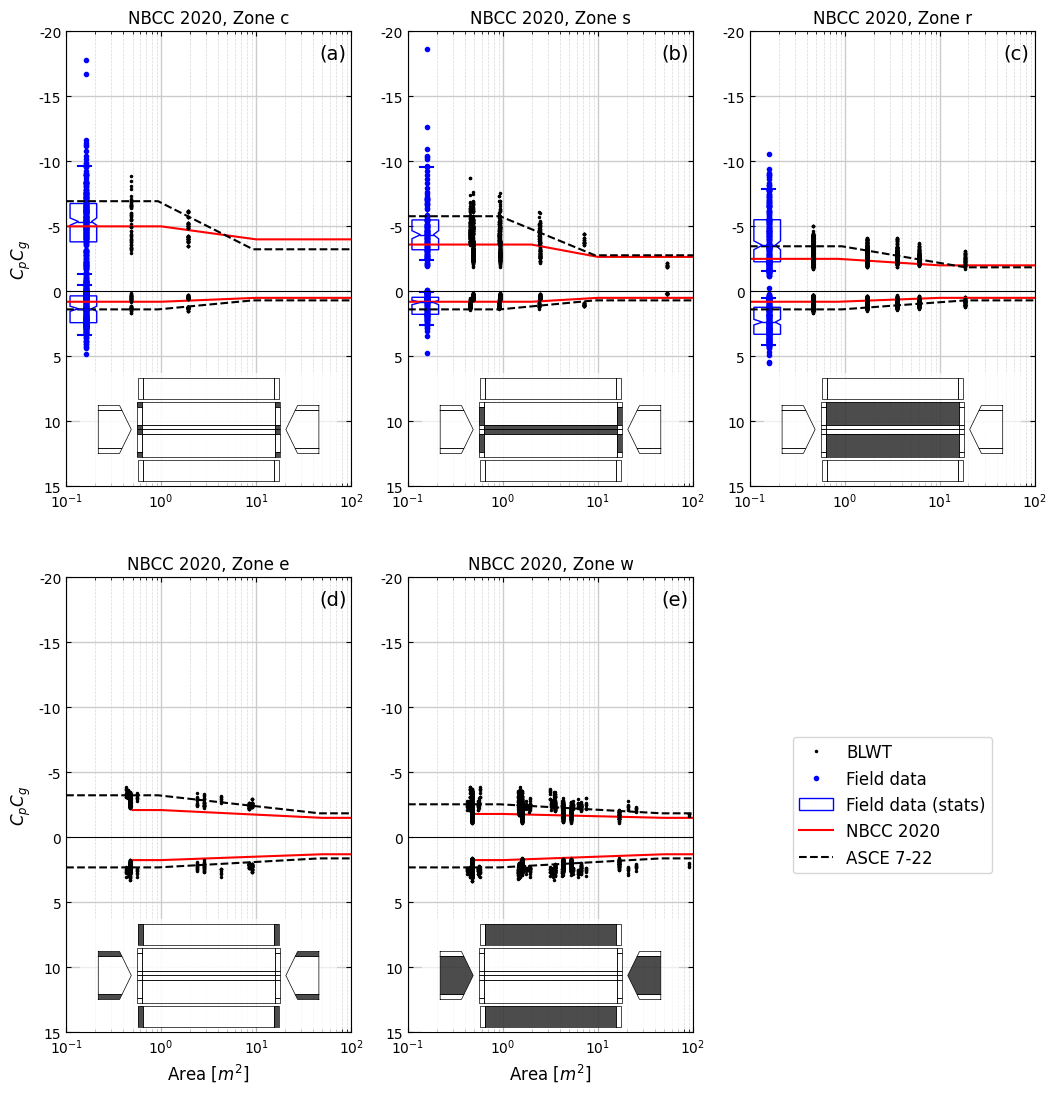

In [93]:
fig = plt.figure(figsize=[12.5,13])
plt.tight_layout()

NumZones = bldg_3to12.NumZones
nCols = min(3, NumZones)
nRows = int(np.ceil(NumZones/nCols))
axs = fig.subplots(nRows, nCols, sharex=False, sharey=False)

for I, zKey in enumerate(bldg_3to12.zoneDictKeys):
    i, j = np.unravel_index(I, axs.shape)
    ax = axs[i,j]
    ax.set_title(zKey)
    if i == axs.shape[0]-1:
        ax.set_xlabel(r'Area [$m^2$]')
    if j == 0:
        ax.set_ylabel(r"$C_pC_g$")
    ax.set_xlim([0.1,100])
    ax.set_ylim([-20,15])

    wind.formatAxis(ax, gridMinor=True)

NBCC_dxnFactor = 0.8
for i, cp in enumerate([cp_3to12, cp_iso_SU]):
    if i == 0:
        _, _, area, peakMin, peakMax = cp.plotCandC_load(fig=fig, axs=axs, 
                                figSize=[12.5,14], sharex=False, sharey=False,
                                plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2, invertYAxis=True,
                                # xLimits=[0.1,100], yLimits=[-23,5],
                                debugMode=True,
                                CandCLoadFormat='NBCC',
                                yLabel=r"$C_pC_g$",
                                label_min=r"BLWT", label_max=None,
                                kwargs_min={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                kwargs_max={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                overlayThese=[
                                    fieldCandC,
                                    windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a'),
                                    windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a', outAs='NBCC'),
                                    ],
                                overlayFactors=[
                                    correctionFactor,
                                    1.0, #/NBCC_dxnFactor,
                                    (windCodes.getDurstFactor(3.0))**2,
                                    ],
                                overlayTypes=['errorBars','single','single'],
                                overlayFirstInLegend=False,
                                kwargs_overlay=(
                                    {'color':'b', 'linestyle':'None', 'marker':'.', 'markersize':6,'markeredgewidth':1.0},
                                    {'color':'r',}, 
                                    {'color':'k', 'linestyle':'--'},
                                    ),
                                legend_ax_idx=5,
                                kwargs_legend={'loc':'center', 'fontsize':12},
                                subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.89,0.94],
                                kwargs_ax={'gridMinor':True},
                                insetBounds=[0.05,0.0,0.9,0.25],
                                zoneShadeColor='k',
                                )
    else:
        _ = cp.plotCandC_load(fig=fig, axs=axs, 
                                figSize=[12.5,14], sharex=False, sharey=False,
                                plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2, #invertYAxis=True,
                                # xLimits=[0.1,100], yLimits=[-23,5],
                                debugMode=True,
                                CandCLoadFormat='NBCC',
                                yLabel=r"$C_pC_g$",
                                label_min=None, label_max=None,
                                overlayFirstInLegend=False,
                                kwargs_min={'color':'k', 'marker':'.', 'markersize':3,},
                                kwargs_max={'color':'k', 'marker':'.', 'markersize':3,},
                                legend_ax_idx=5,
                                kwargs_legend={'loc':'center', 'fontsize':12},
                                kwargs_ax={'gridMinor':True},
                                insetBounds=[0.05,0.0,0.9,0.3],
                                zoneShadeColor='k',
                                plotZoneGeom=False,
                                )
plt.show()

# if saveFigs:
fig.savefig(figDir+"CandC_Fig_E_iso_noNBCC_scl_FSz0corr.svg",format='svg',dpi=1200, bbox_inches='tight')
# print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")
